In [159]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [160]:
df = pd.read_csv('./train.csv', sep=',', index_col='Id')

In [161]:
df.shape

(10000, 11)

In [162]:
df.columns

Index(['age', 'years_of_experience', 'lesson_price', 'qualification',
       'physics', 'chemistry', 'biology', 'english', 'geography', 'history',
       'mean_exam_points'],
      dtype='object')

In [163]:
df.dtypes

age                    float64
years_of_experience    float64
lesson_price           float64
qualification          float64
physics                float64
chemistry              float64
biology                float64
english                float64
geography              float64
history                float64
mean_exam_points         int64
dtype: object

In [164]:
df.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
Id,,,,,,,,,,,
0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,61
1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,76
2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53
3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,54
4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57


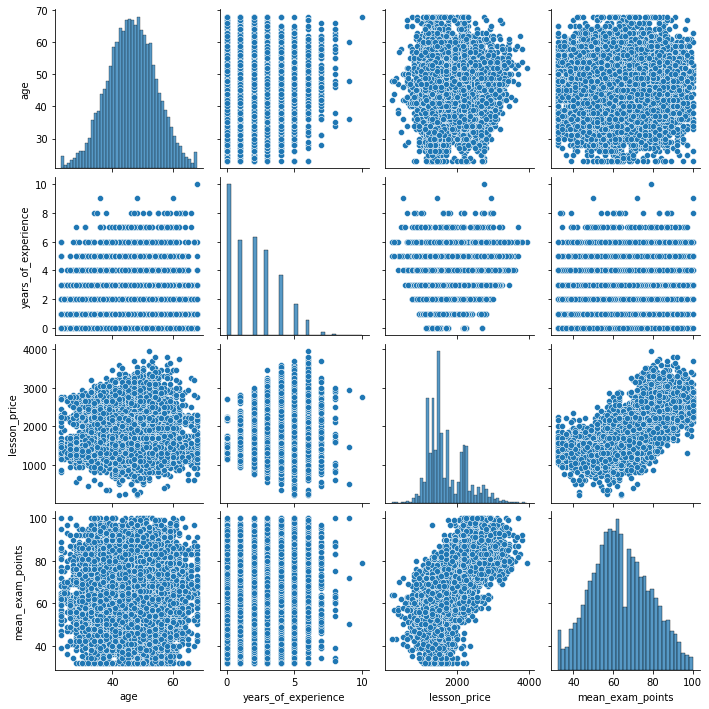

In [165]:
# Для обзора используем сетку графиков по нескольким признакам

sns.pairplot(df, vars=['age', 'years_of_experience', 'lesson_price', 'mean_exam_points'])

<AxesSubplot:xlabel='age'>

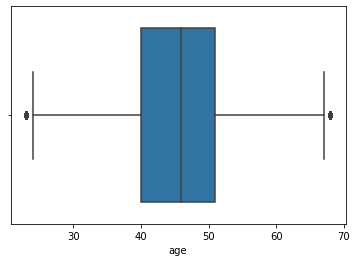

In [37]:
sns.boxplot(x=df["age"])

<AxesSubplot:xlabel='years_of_experience'>

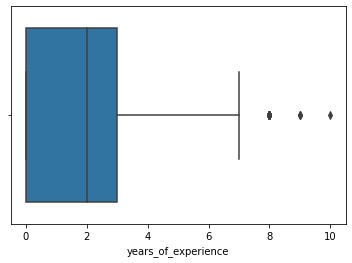

In [34]:
sns.boxplot(x=df["years_of_experience"])

In [124]:
df.describe()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,63.737300
std,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,14.705574
min,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.000000
50%,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.000000
max,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [7]:
# Проверяем, нет ли пустых значений в датасете

np.where(pd.isnull(df))

(array([], dtype=int64), array([], dtype=int64))

In [166]:
Y = df['mean_exam_points']
X = df
del X['mean_exam_points']

In [167]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [168]:
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

In [169]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

In [170]:
z0 = np.ones((X_test.shape[0],))
z0 = pd.Series(z0)

In [171]:
# классический  GD
def gradient_descent(X, y, iterations, eta=1e-3):
    n = X.shape[0]
    z = pd.Series(np.ones((n,)))
    X['w0'] = z.values
    W = np.random.randn(X.shape[1])
    
    for i in range(0, iterations):
        y_pred = np.dot(X, W)
        err = calc_mse(y, y_pred)
       
        dQ = 2/n * X.T @ (y_pred - y) # градиент функции ошибки
        
        W -= (eta * dQ)
        if i % (iterations / 10) == 0:
            eta /= 1.1
            # print(f'Iter: {i}, weights: {W}, error {err}')
    print(f'Final MSE: {calc_mse(y, np.dot(X, W))}')
    return W

In [172]:
X_train_st = standard_scale(X_train)
Y_train_st = standard_scale(Y_train)
X_test_st = standard_scale(X_test)

In [173]:
W1 = gradient_descent(X_train_st, Y_train, iterations=1000, eta=5e-2)

Final MSE: 96.98913326534256


In [174]:
z0 = np.ones((X_test.shape[0],))
z0 = pd.Series(z0)
X_test_st['W0'] = z0.values

In [175]:
y_pred = np.dot(X_test_st, W1)
calc_mse(Y_test, y_pred)

97.49511036345594

## Вариант с деревом решений.

In [179]:
# Критерий инфомративности для регрессииabs
def inf_crit(array):
    mean = array.mean()
    return np.mean((array - mean)**2)

In [180]:
# Расчет прироста информации

def gain(left_targets, right_targets, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_targets.shape[0]) / (left_targets.shape[0] + right_targets.shape[0])
    
    return root_gini - p * inf_crit(left_targets) - (1 - p) * inf_crit(right_targets)

In [181]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch, deep):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        self.deep = deep #глубина дерева

In [182]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет среднего значения
        prediction = self.targets.mean()
        
        return prediction      

In [183]:
# Разбиение датасета в узле

def split(data, targets, column_index, t):
    
    #определяются индексы объектов с целевым признаком, удовлетворяющим условию
    left = data[column_index] <= t
    right = data[column_index] > t
    
    # формируем таблицы с соответствующими данными
    true_data = data[left]
    false_data = data[right]
    
    # и формируем целевые маркеры
    true_targets = targets[left]
    false_targets = targets[right]
        
    return true_data, false_data, true_targets, false_targets

In [184]:
# Нахождение наилучшего разбиения

def find_best_split(data, targets):
    
    #  обозначим минимальное количество объектов в узле
    # min_samples_leaf = 2

    root_gini = inf_crit(targets)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for col in data:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = data[col].unique()
        
        for t in t_values:
            true_data, false_data, true_targets, false_targets = split(data, targets, col, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
#                continue
            
            current_gain = gain(true_targets, false_targets, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, col

    return best_gain, best_t, best_index

In [188]:
# Построение дерева с помощью рекурсивной функции
# Для ограничения глубины дерева добавим в переменные функции флаг вызова функции, чтобы иметь возможность
# подсчитать количество вызовов и сравнить его с уставкой
def build_tree(data, targets, deep):
    
    
    gain, t, index = find_best_split(data, targets)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0 or deep == 6:   # Добавляем условие сравнения текущей глубины. Если дошли до определнного уровня - выходим.
        return Leaf(data, targets)

    true_data, false_data, true_targets, false_targets = split(data, targets, index, t)
    
    dp = deep + 1
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_targets, deep=dp)

    false_branch = build_tree(false_data, false_targets, deep=dp)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch, deep)

In [189]:
def prediction_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return prediction_object(obj, node.true_branch)
    else:
        return prediction_object(obj, node.false_branch)

In [190]:
def predict(data, tree):
    
    pred = []
    for obj in data.index:
        prediction = prediction_object(data.loc[obj], tree)
        pred.append(prediction)
    return pred

In [191]:
# Обучаем дерево
tree = build_tree(X_train, Y_train, deep=0)

In [192]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t), 'Глубина', str(node.deep))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [193]:
print_tree(tree)

Индекс lesson_price <= 1900.0 Глубина 0
--> True:
  Индекс qualification <= 1.0 Глубина 1
  --> True:
    Индекс lesson_price <= 1450.0 Глубина 2
    --> True:
      Индекс physics <= 0.0 Глубина 3
      --> True:
        Индекс lesson_price <= 1250.0 Глубина 4
        --> True:
          Индекс years_of_experience <= 0.0 Глубина 5
          --> True:
            Прогноз: 52.04365079365079
          --> False:
            Прогноз: 54.12186978297162
        --> False:
          Индекс years_of_experience <= 0.0 Глубина 5
          --> True:
            Прогноз: 61.13588850174216
          --> False:
            Прогноз: 54.889583333333334
      --> False:
        Индекс lesson_price <= 1250.0 Глубина 4
        --> True:
          Индекс lesson_price <= 1200.0 Глубина 5
          --> True:
            Прогноз: 59.54299754299754
          --> False:
            Прогноз: 57.276785714285715
        --> False:
          Индекс years_of_experience <= 0.0 Глубина 5
          --> True:
        

In [194]:
pred_train = predict(X_train, tree)

In [195]:
pred_val = predict(X_test, tree)

In [196]:
# Погрешность на тренировочных данных
print('Погрешность на тренировочных данных - ' + str(calc_mse(Y_train, pred_train)))

# Погрешность на валидационных данных
print('Погрешность на валидационных данных - ' + str(calc_mse(Y_test, pred_val)))

Погрешность на тренировочных данных - 71.7362605392874
Погрешность на валидационных данных - 76.34246087996262


In [197]:
test = pd.read_csv('./test.csv', sep=',', index_col='Id')

In [198]:
pred_test = pd.Series(predict(test, tree))

In [199]:
pred_test.index = pred_test.index + 10000

In [200]:
pred_test.to_csv('./sample_submission.csv', header=['mean_exam_points'], index_label='Id')